# 1D kernel basics

This example will cover:

 - Initialising the GPvecchia class with a kernel and some 1D data
 - Sampling from the prior
 - Making a prediction at new points
 - Sampling from the conditional distribution

In [3]:
from gpvecchia.vecchia import GPtideVecchia
import numpy as np
import matplotlib.pyplot as plt

We use an exponential-quadratic  kernel with a length scale $\ell$ = 100 and variance $\eta$ = $1.5^2$. The noise ($\sigma$) is 0.5. The total length of the domain is 2500 and we sample 100 data points.

`GPvecchia` only accepts covariance functions that use a distance matrix. 

In [4]:
from numba import njit

@njit(cache=True)
def expquad(d, l):
    """Exponential quadration base function/Squared exponential/RBF"""
    return np.exp(-d**2/(2*l**2))

In [8]:
####
# These are our kernel input parameters
noise = 0.2
η = 1.5
ℓ = 100
covfunc = expquad

###
# Domain size parameters
dx = 25.
N = 10000
covparams = (η, ℓ)

# Input data points
xd = np.arange(0,dx*N,dx)[:,None]

# A re-ordering function should always be specified - the default is no re-ordering
order_func = np.random.permutation
order_params = len(xd)

## Initialise the GPtide object and sample from the prior

Always specify a re-ordering function. Other optional args can be left as default.


Text(0.5, 0, 'x')

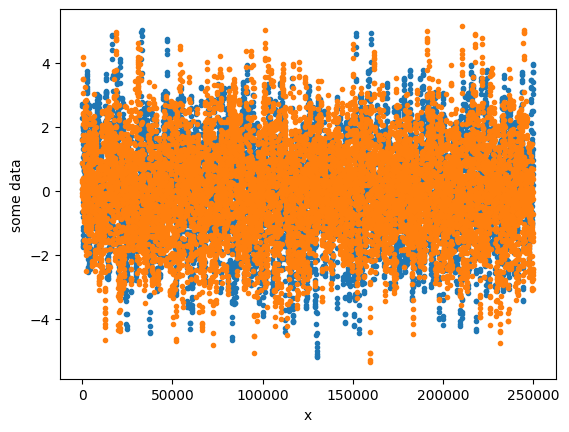

In [9]:
GP = GPtideVecchia(xd, xd, noise, covfunc, covparams, order_func=order_func, order_params=order_params)

# Use the .prior() method to obtain some samples
yd = GP.sample_prior(samples=1)

# Note the default is to not add noise
yd_noisy = GP.sample_prior(samples=1, add_noise=True)

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xd, yd_noisy,'.')
plt.ylabel('some data')
plt.xlabel('x')

One random sample has noise, the other does not.

## Make a prediction at new points using noisy data


(4760.10020200404, 9765.190303806075)

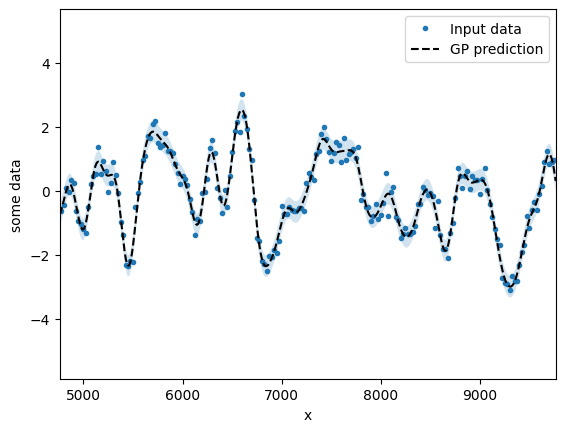

In [17]:
# Output data points 
xo = np.linspace(-10*dx,dx*N+dx*10,N*5)[:,None]

# Create a new object with the output points
GP2 = GPtideVecchia(xd, xo, noise, covfunc, covparams,
                    order_func=order_func, order_params=order_params)

# Predict the mean
y_mu, y_std = GP2(yd_noisy)

plt_ix = np.arange(1000,2000)
plt.figure()
plt.plot(xd, yd_noisy,'.')
plt.plot(xo[plt_ix], y_mu[plt_ix],'k--')
plt.fill_between(xo.flatten()[plt_ix],
                 (y_mu.flatten()-y_std.flatten())[plt_ix],
                 (y_mu.flatten()+y_std.flatten())[plt_ix],
                 alpha=0.2)
plt.legend(('Input data','GP prediction'))
plt.ylabel('some data')
plt.xlabel('x')
plt.xlim([xo[plt_ix[0]],xo[plt_ix[-1]]])

## Make a prediction of the full conditional distribution at new points

(-250.0, 4755.090101802036)

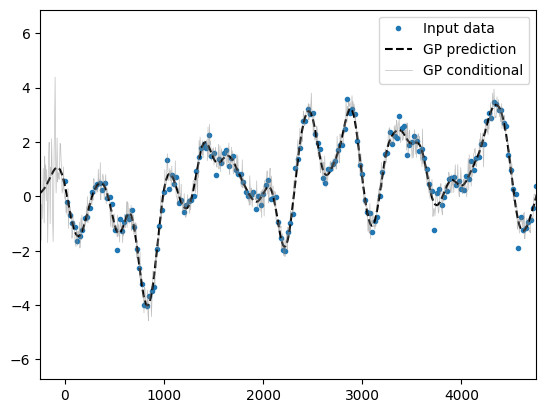

In [13]:
samples = 1
y_conditional = GP2.conditional(yd_noisy, samples=samples)

plt_ix = np.arange(0,1000)
plt.figure()
plt.plot(xd, yd_noisy,'.')
plt.plot(xo, y_mu,'k--')

for ii in range(samples):
    plt.plot(xo[:,0], y_conditional[:,ii],'0.5', lw=0.5, alpha=0.5)
    
plt.legend(('Input data','GP prediction','GP conditional'))
plt.xlim([xo[plt_ix[0]],xo[plt_ix[-1]]])

You can see that in the current implementation of Vecchia the estimates at prediction points do not consider other prediction points, only the input points. This makes draws from the conditional distribution ***incorrect***, as each point is independent of other points in the posterior sample. You can see the draw is overly noisy both around input data and more so away from input data. 
